
## **Part C** <font color="blue">(4 points)</font>
Apply SVM and random forests to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to each other? Which of them yields the best performance?


##### Importing Libraries

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd

#import statsmodels.api as sm
#from sklearn.metrics import mean_squared_error
#from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm #, linear_model

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score #, r2_score

#from sklearn.svm import SVR
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import GridSearchCV

##### Helper Function(s)

In [2]:
# for each column, display column name & its distinct contents ONLY in case the column has less than 6 unique values
def get_columns_and_distinct_values(df,nunique_target=5):
  str_=""
  ret=[]
  for column in df:
      columnSeriesObj = df[column]
      nunique_this_clmn = columnSeriesObj.nunique()
      str_ = 'Column Name: ' + column + ', Column Type: ' + str(df[column].dtype)
      if nunique_this_clmn == 1:
          str_ = str_ + ', Column has one unique value only and can be dropped from the dataframe'
          ret.append(str_)
          ret.append("------------------------------------------------------------")
      elif nunique_this_clmn <= nunique_target:
        str_ = str_ + ', Column has ' + str(columnSeriesObj.nunique()) + ' unique value(s) : '
        for val in columnSeriesObj.unique():
          str_ = str_  + str(val) + ","
        str_ = str_[:len(str_)-1]
        ret.append(str_)
        ret.append("------------------------------------------------------------")
      else:
        str_ = str_ + ', Column has more than ' + str(nunique_target) + ' unique values'
      #ret.append(str_)
      #ret.append("==========================================================================")

  print("==========================================================================")
  columns_of_type_object = df.select_dtypes(include=['object']).columns
  print("*** Columns of type object are:", columns_of_type_object)
  print("==========================================================================")
  columns_of_a_single_unique_value = df.columns[df.nunique() == 1]
  print("*** Columns of a single unique value are:", columns_of_a_single_unique_value, " can be dropped")
  print("==========================================================================")
  return ret

##### Titanic Data Description
***Passenger ID*** to identify the passenger, numerical feature (Passenger ID/Ticket Number).

***Survived*** is our label, as we can see is a binary feature, 1 if survived and 0 otherwise.

***Pclass*** is the Ticket class (1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (lower))

***Name *** is the name of the passenger

***Sex*** is the gender of the passenger

***Age*** is the age in years

***Sibsp*** is the number of siblings / spouses aboard the Titanic

***Parch*** is the number of parents / children aboard the Titanic

***Ticket*** is the ticket number

***Fare*** is the Passenger fare

***Cabin*** is the cabin number

***Embarked*** means Port of Embarkation. C = Cherbourg, Q = Queenstown, S = Southampton

##### Titanic Train Data

In [3]:
# load train data from train.csv
titanic_train_df = pd.read_csv(r'titanic_train.csv')
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

##### EDA Train Data

In [5]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_train_df.shape

(891, 12)

In [7]:
# check for NULL values
if titanic_train_df.isnull().any().sum() > 0:
    print("There are:" , titanic_train_df.isnull().any().sum(), "Null values in the train data")
else:
    print("Train data is good - There is no null values in any of the columns")

There are: 3 Null values in the train data


In [8]:
titanic_train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
titanic_train_df.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

In [10]:
print ("titanic_train_df:")
#print("null values:\n", titanic_train_df.isnull().sum())
print("duplicated records", titanic_train_df.duplicated().sum())

titanic_train_df:
duplicated records 107


##### Handle Nan values

###### Embarked Feature / Two Records with Nan values - Drop

In [11]:
# Two records in titanic_train_df with Nan in Embarked feature  - will be dropped from the dataframe
titanic_train_df[titanic_train_df['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


In [12]:
print(titanic_train_df['Embarked'].value_counts())
# most passengers are emabrked from S = Southampton (Three ports of Embarkation C = Cherbourg; Q = Queenstown; S = Southampton)

# replace the 2 NULL values in embarked with S = Southampton (as most passengers on Titanic embarked from this port)
titanic_train_df.loc[titanic_train_df['Embarked'].isnull(),'Embarked'] = 'S'

print(titanic_train_df['Embarked'].value_counts())

titanic_train_df[titanic_train_df['Embarked'].isnull()]

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked


###### Cabin Feature / replace missing values in titanic_train_df['Cabin'] with letter 'U' for unknown

In [13]:
print("null values in the Cabin Feature:\n", titanic_train_df.isnull().sum()['Cabin'], "Records")

null values in the Cabin Feature:
 687 Records


In [14]:
titanic_train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [15]:
# keep first letter only in the Cabin
titanic_train_df['Cabin'] = titanic_train_df['Cabin'].str[0]
titanic_train_df['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [16]:
# replace missing values in titanic_train_df['Cabin'] with letter 'U' for unknown
titanic_train_df['Cabin'].fillna('U', inplace=True)

In [17]:
titanic_train_df['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

###### Age Feature / replace missing values in titanic_train_df['Age'] with the avergae of age

In [18]:
print("null values in the Age Feature:\n", titanic_train_df.isnull().sum()['Age'], "Records")

null values in the Age Feature:
 177 Records


In [19]:
# Fill missing/Nan values in Age with average age
titanic_train_df['Age'].fillna(titanic_train_df['Age'].mean(), inplace=True)  # 29.642093
print("null values in the Age Feature:\n", titanic_train_df.isnull().sum()['Age'], "Records")
#titanic_train_df['Age'].unique()


null values in the Age Feature:
 0 Records


In [20]:
# Check again after fixing missing records
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [21]:
titanic_train_df.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,9,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,U,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,687,646
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,13.002015,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,29.699118,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,31.000000,NaN,NaN


In [22]:
titanic_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,U,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,U,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,U,S


In [23]:
ret=get_columns_and_distinct_values(titanic_train_df,10)
for str_ in ret:
  print(str_)

*** Columns of type object are: Index(['Sex', 'Cabin', 'Embarked'], dtype='object')
*** Columns of a single unique value are: Index([], dtype='object')  can be dropped
Column Name: Survived, Column Type: int64, Column has 2 unique value(s) : 0,1
------------------------------------------------------------
Column Name: Pclass, Column Type: int64, Column has 3 unique value(s) : 3,1,2
------------------------------------------------------------
Column Name: Sex, Column Type: object, Column has 2 unique value(s) : male,female
------------------------------------------------------------
Column Name: SibSp, Column Type: int64, Column has 7 unique value(s) : 1,0,3,4,2,5,8
------------------------------------------------------------
Column Name: Parch, Column Type: int64, Column has 7 unique value(s) : 0,1,2,5,3,4,6
------------------------------------------------------------
Column Name: Cabin, Column Type: object, Column has 9 unique value(s) : U,C,E,G,D,A,B,F,T
-----------------------------

###### Use data for ***Fare & Cabin*** to provide ***better/more accurate*** values for the "U = Unknown" cabins for some/many records

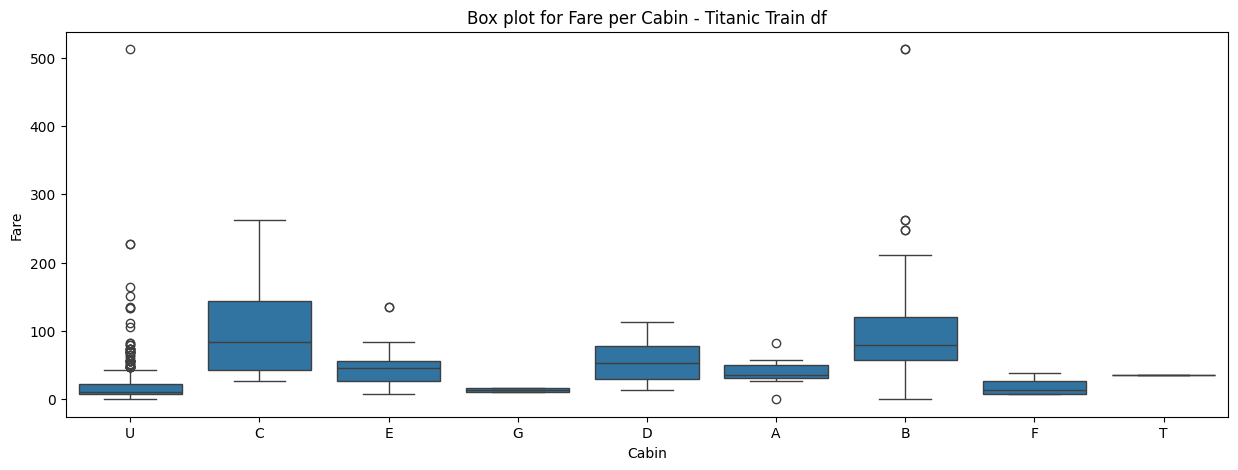

In [24]:
# plot using box plot to check for outliers of Fare for the Unknown Cabins (Train df)
plt.figure(figsize=(15,5))
plt.title("Box plot for Fare per Cabin - Titanic Train df")
sns.boxplot(x='Cabin', y='Fare',data=titanic_train_df)
plt.show()

In [25]:
def cbnFareDataToDataFrame(titanic_df):
  CntCbnFare, MinCbnFare, MaxCbnFare, AvgCbnFare, MedianCbnFare, ModeCbnFare = [],[],[],[],[],[]
  for cbn in titanic_df['Cabin'].unique(): #'ABCDEFGTU':
    condition = (titanic_df['Cabin'] == cbn) & (titanic_df['Fare']!=0)

    #strCbnFareInfo = "For Cabin: " + cbn

    cnt=titanic_df[condition]['Fare'].count()
    #strCbnFareInfo += " ===> Count=" + str(cnt)
    CntCbnFare.append(cnt)

    min_=round(titanic_df[condition]['Fare'].min(),2)
    #strCbnFareInfo += ", Min Fare=" + str(min)
    MinCbnFare.append(min_)

    max_=round(titanic_df[condition]['Fare'].max(),2)
    #strCbnFareInfo += ", Max=" + str(max_)
    MaxCbnFare.append(max_)

    Mean_=round(titanic_df[condition]['Fare'].mean(),2)
    #strCbnFareInfo += ", Mean=" + str(Mean_)
    AvgCbnFare.append(Mean_)

    Median_=round(titanic_df[condition]['Fare'].median(),2)
    #strCbnFareInfo += ", Median=" + str(Median_)
    MedianCbnFare.append(Median_)

    Mode_=round(titanic_df[condition]['Fare'].mode().mean(),2)
    #strCbnFareInfo += ", Mode=" + str(Mode_)
    ModeCbnFare.append(Mode_)

  #print(strCbnFareInfo)

  dict = {'Cbn': list(titanic_df['Cabin'].unique()), 'Count': CntCbnFare, 'Min': MinCbnFare, 'Max': MaxCbnFare, 'Mean': AvgCbnFare, 'Median': MedianCbnFare, 'Mode': ModeCbnFare}
  cbnFareDf = pd.DataFrame(dict)
  cbnFareDf.head(len(titanic_df['Cabin'].unique()))

  #print(cbnFareDf.sort_values(by=['Median','Mean', 'Mode'], ascending=[True,True, True]))
  return cbnFareDf

In [26]:
cbnFareTrainDf = cbnFareDataToDataFrame(titanic_train_df)
#cbnFareDf.head(len('ABCDEFGTU'))
print(cbnFareTrainDf.sort_values(by=['Mean','Median','Mode'], ascending=[False,False, False]))

  Cbn  Count    Min     Max    Mean  Median    Mode
6   B     45   5.00  512.33  118.55   80.00  120.00
1   C     59  26.55  263.00  100.15   83.48  126.52
4   D     33  12.88  113.28   57.24   53.10   80.13
2   E     32   8.05  134.50   46.03   45.18   44.16
5   A     14  26.00   81.86   42.45   37.55   35.50
8   T      1  35.50   35.50   35.50   35.50   35.50
0   U    675   4.01  512.33   19.50   11.13    8.05
7   F     13   7.65   39.00   18.70   13.00   16.82
3   G      4  10.46   16.70   13.58   13.58   13.58


In [27]:
# first obsevation (only for titanic train) that there is only one entry for cabin T so high probability
# it is a data-issue - will fix to Cabin A as same Mode & closed Median & Mean
titanic_train_df.loc[titanic_train_df['Cabin'] == 'T', 'Cabin'] = 'A'

cbnFareTrainDf = cbnFareDataToDataFrame(titanic_train_df)
print(cbnFareTrainDf.sort_values(by=['Mean','Median','Mode'], ascending=[False,False, False]))

  Cbn  Count    Min     Max    Mean  Median    Mode
6   B     45   5.00  512.33  118.55   80.00  120.00
1   C     59  26.55  263.00  100.15   83.48  126.52
4   D     33  12.88  113.28   57.24   53.10   80.13
2   E     32   8.05  134.50   46.03   45.18   44.16
5   A     15  26.00   81.86   41.99   35.50   35.50
0   U    675   4.01  512.33   19.50   11.13    8.05
7   F     13   7.65   39.00   18.70   13.00   16.82
3   G      4  10.46   16.70   13.58   13.58   13.58


In [28]:
# second obsevation that there are many entries for cabin U which has many outliers (also from the above boxplot)
# so fix this data issue by assigning a different cabin based on fare Mean
#print(cbnFareTrainDf.sort_values(by=['Max'], ascending=[False]))

In [29]:
cndTrain1 = (titanic_train_df['Cabin'] == 'U')

cndTrain2 = (titanic_train_df['Fare'] > 100.15)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'B'

cndTrain2 = (titanic_train_df['Fare'] <= 100.15) & (titanic_train_df['Fare'] > 57.24)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'C'

cndTrain2 = (titanic_train_df['Fare'] <= 57.24) & (titanic_train_df['Fare'] > 46.03)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'D'

cndTrain2 = (titanic_train_df['Fare'] <= 46.03) & (titanic_train_df['Fare'] > 41.99)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'E'

cndTrain2 = (titanic_train_df['Fare'] <= 41.99) & (titanic_train_df['Fare'] > 18.70)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'A'

cndTrain2 = (titanic_train_df['Fare'] <= 18.70) & (titanic_train_df['Fare'] > 13.58)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'F'

cndTrain2 = (titanic_train_df['Fare'] <= 13.58) & (titanic_train_df['Fare'] > 7.65)
titanic_train_df.loc[cndTrain1 & cndTrain2, 'Cabin'] = 'G'

#print("For Training Data")
cbnFareTrainDf = cbnFareDataToDataFrame(titanic_train_df)
print(cbnFareTrainDf.sort_values(by=['Max'], ascending=[False]))

  Cbn  Count    Min     Max    Mean  Median    Mode
7   B     55   5.00  512.33  131.61   91.08  120.00
1   C     79  26.55  263.00   92.87   73.50   69.55
3   E     33   8.05  134.50   45.92   42.40   44.16
6   D     50  12.88  113.28   55.33   52.55   56.50
4   A    178  18.75   81.86   28.29   26.25   26.00
5   F     79   7.65   39.00   15.95   15.50   16.10
2   G    324   7.72   16.70    9.21    8.05    8.05
0   U     78   4.01    7.65    7.12    7.23    7.23


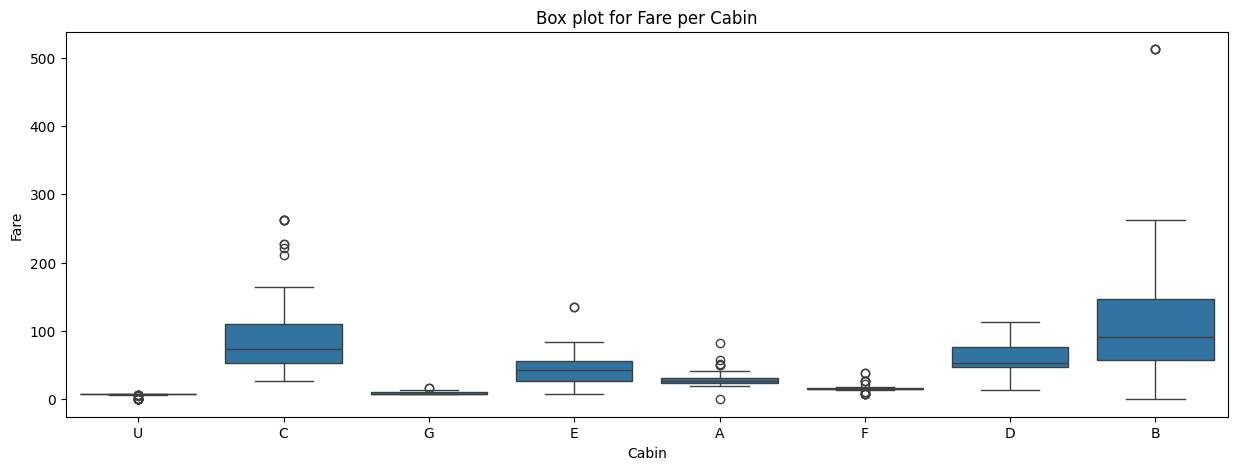

In [30]:
# plot using box plot to check for Fare per Cabin after above step (Train)
plt.figure(figsize=(15,5))
plt.title("Box plot for Fare per Cabin")
sns.boxplot(x='Cabin', y='Fare',data=titanic_train_df)
plt.show()

In [31]:
titanic_train_df2 = pd.get_dummies(titanic_train_df)
titanic_train_df2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,False,False,False,False,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,False,False,True,False,False,False,False,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,False,False,False,False,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,False,False,False,False,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,False,False,False,False,True,False,False,False,True


In [32]:
X_tnc_train=titanic_train_df2.drop(['Survived'],axis=1)
y_tnc_train=titanic_train_df2['Survived']

In [33]:
# scale data separately for train and test
scaler = StandardScaler().fit(X_tnc_train)
X_train_scaled = scaler.transform(X_tnc_train)

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y_tnc_train,test_size=0.2)

##### Random Forest

In [35]:
rfc= RandomForestClassifier(n_estimators=100,random_state=47)
rfc.fit(X_train,y_train)
y_train_predict_rfc=rfc.predict(X_train)

print("train accuracy_score", accuracy_score(y_train, y_train_predict_rfc))
print("train f1_score", f1_score(y_train, y_train_predict_rfc, average="macro"))
print("train precision_score",precision_score(y_train, y_train_predict_rfc, average="macro"))   # "macro" ---> does not take into account imbalance
print("train recall_score",recall_score(y_train, y_train_predict_rfc, average="macro"))
print("test rfc score",rfc.score(X_train,y_train))

train accuracy_score 0.9845505617977528
train f1_score 0.9836737756895182
train precision_score 0.9861153008211831
train recall_score 0.9814556620606665
test rfc score 0.9845505617977528


In [36]:
y_test_predict_rfc = rfc.predict(X_test)
print("test accuracy_score", accuracy_score(y_test, y_test_predict_rfc))
print("test f1_score",f1_score(y_test, y_test_predict_rfc, average="macro"))
print("test precision_score",precision_score(y_test, y_test_predict_rfc, average="macro"))   # "macro" ---> does not take into account imbalance
print("test recall_score",recall_score(y_test, y_test_predict_rfc, average="macro"))
print("test rfc score",rfc.score(X_test,y_test))

test accuracy_score 0.7988826815642458
test f1_score 0.7811141304347826
test precision_score 0.7831828133552271
test recall_score 0.7792847503373819
test rfc score 0.7988826815642458


[  1   2   4   8  16  32  64 128 256]


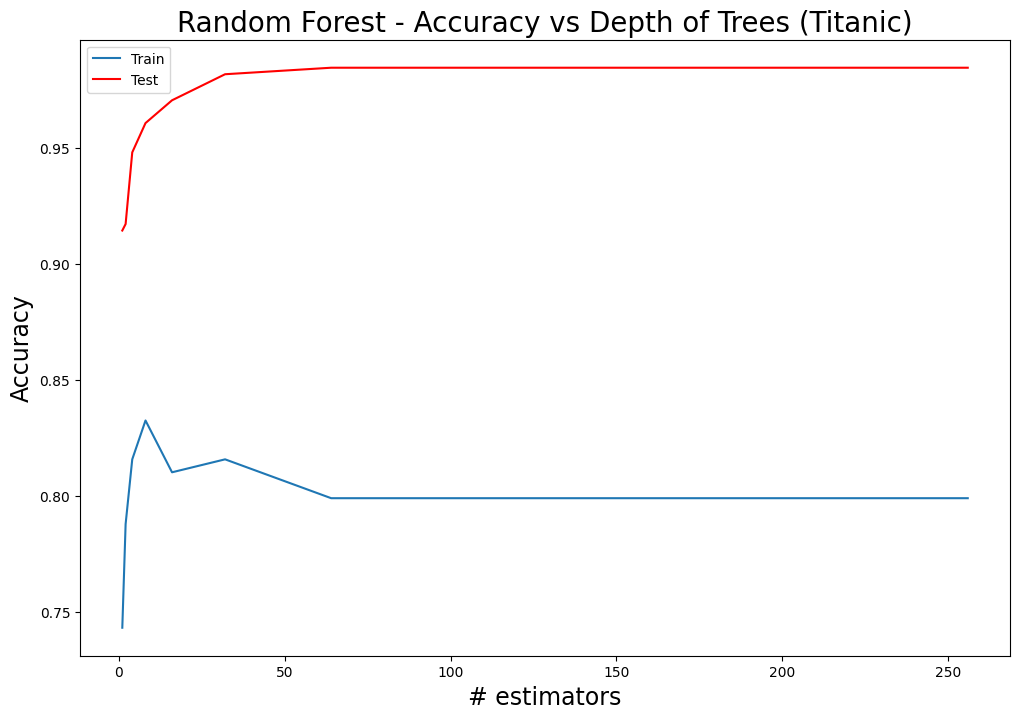

In [37]:
figsize = plt.figure(figsize = (12,8))
# Initialize the accuracy_score vector
acc = []              # test accuracy
acc_train = []        # train accuracy
estimators = 2 ** np.arange(9)
print(estimators)

# Calculate accuracy score on the test set for different values for the n_estimators parameter
for est in estimators:
    # Fit the Regression Tree
    rfc2 = RandomForestClassifier(n_estimators=est, random_state=47) #max_depth=i,
    rfc2.fit(X_train,y_train)
    # Predict on the test set
    y_pred = rfc2.predict(X_test)
    # Compute the accuracy
    score = accuracy_score(y_test, y_pred)
    acc.append(score)
    acc_train.append(accuracy_score(y_train, rfc2.predict(X_train)))

# Plot results
#print(acc)
#print(acc_train)
plot = plt.plot(estimators, acc, '-', estimators, acc_train, 'r')
#plot = plt.plot(estimators, acc_train, 'b', label='Train')
#plot = plt.plot(estimators, acc, 'r', label='Test')
xlab = plt.xlabel('# estimators', fontsize = 17)
ylab = plt.ylabel('Accuracy', fontsize = 17)
plt.legend(['Train','Test'])
title = plt.title('Random Forest - Accuracy vs Depth of Trees (Titanic)', fontsize = 20);

###### Random Forest Accuracy Results

In [38]:
# best value for estimators:
print("Using Random forest with different number of estimators, best accuracy was at", max(acc),"and it occurs when estimators=", estimators[acc.index(max(acc))])

Using Random forest with different number of estimators, best accuracy was at 0.8324022346368715 and it occurs when estimators= 8


#### SVM

In [39]:
svc=SVC(C=1000) #kernel='rbf',
svc.fit(X_train,y_train)

SVC(C=1000)

In [40]:
y_train_predict_svc=svc.predict(X_train)

print("train accuracy_score", accuracy_score(y_train, y_train_predict_svc))
print("train f1_score", f1_score(y_train, y_train_predict_svc, average="macro"))
print("train precision_score",precision_score(y_train, y_train_predict_svc, average="macro"))   # "macro" ---> does not take into account imbalance
print("train recall_score",recall_score(y_train, y_train_predict_svc, average="macro"))
print("test svc score",svc.score(X_train,y_train))

train accuracy_score 0.922752808988764
train f1_score 0.9170295036813391
train precision_score 0.92853170189099
train recall_score 0.9092451968961368
test svc score 0.922752808988764


In [41]:
y_test_predict_svc = svc.predict(X_test)
print("test accuracy_score", accuracy_score(y_test, y_test_predict_svc))
print("test f1_score",f1_score(y_test, y_test_predict_svc, average="macro"))
print("test precision_score",precision_score(y_test, y_test_predict_svc, average="macro"))   # "macro" ---> does not take into account imbalance
print("test recall_score",recall_score(y_test, y_test_predict_svc, average="macro"))
print("test svc score",svc.score(X_test,y_test))

test accuracy_score 0.770949720670391
test f1_score 0.7440806221013355
test precision_score 0.7555168408826946
test recall_score 0.7375168690958165
test svc score 0.770949720670391


[  1   2   4   8  16  32  64 128 256]


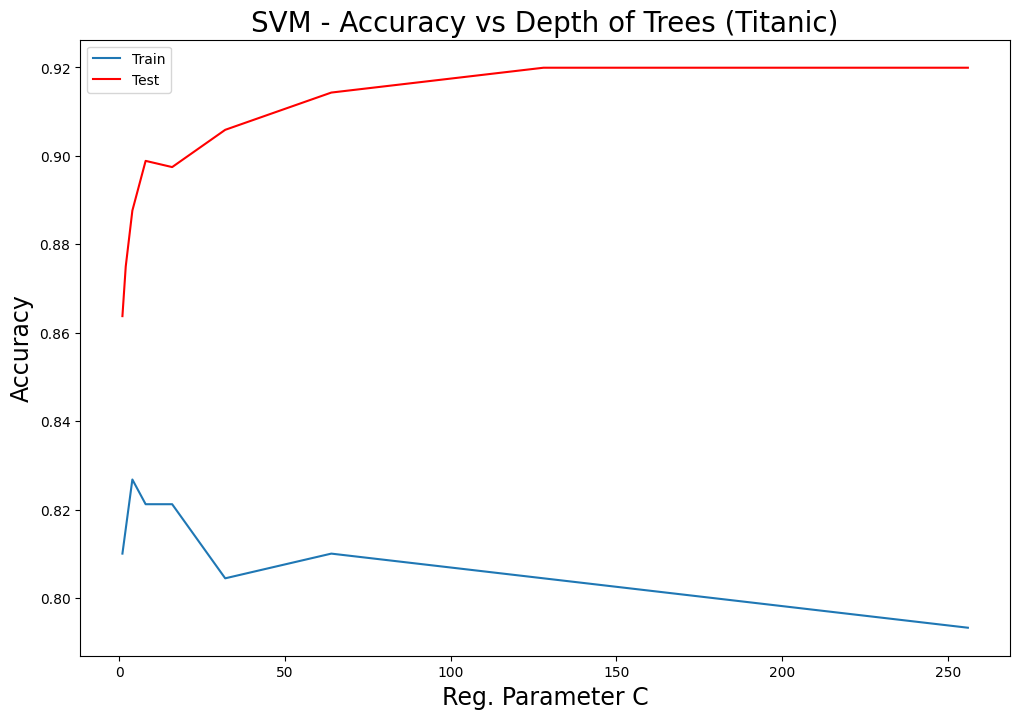

In [42]:
figsize = plt.figure(figsize = (12,8))
# Initialize the accuracy_score vector
acc = []              # test accuracy
acc_train = []        # train accuracy
reglCs = 2 ** np.arange(9)
print(reglCs)

# Calculate accuracy score on the test set for different values for the regularization parameter C
for C_param in reglCs:
    # Fit the Regression Tree
    svc2 = SVC(C=C_param) #max_depth=i,
    svc2.fit(X_train,y_train)
    # Predict on the test set
    y_pred = svc2.predict(X_test)
    # Compute the accuracy
    score = accuracy_score(y_test, y_pred)
    acc.append(score)
    acc_train.append(accuracy_score(y_train, svc2.predict(X_train)))

# Plot results
#print(acc)
#print(acc_train)
plot = plt.plot(reglCs, acc, '-', reglCs, acc_train, 'r')
#plot = plt.plot(reglCs, acc_train, 'b', label='Train')
#plot = plt.plot(reglCs, acc, 'r', label='Test')
xlab = plt.xlabel('Reg. Parameter C', fontsize = 17)
ylab = plt.ylabel('Accuracy', fontsize = 17)
plt.legend(['Train','Test'])
title = plt.title('SVM - Accuracy vs Depth of Trees (Titanic)', fontsize = 20);

In [43]:
# best value for estimators:
print("Using SVM with different values for the regularization parameter C, best accuracy was at", max(acc),"and it occurs when C=", reglCs[acc.index(max(acc))])

Using SVM with different values for the regularization parameter C, best accuracy was at 0.8268156424581006 and it occurs when C= 4
